<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/RylaBerrU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analyzing Spongebob Viewership on Episode Release from Season to Season**

##Installs & Imports

In [1]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompatible.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompa

In [2]:
import preliz as pz

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm

##Context
Previously, I analysized Spongebob viewership from the series as a whole. But while viewing the data, more recent seasons seemed to have less viewership compared to a decade ago. I hope to learn whether the difference between seasons will be distinct or if there is some underlying correlation accross seasons.

##Previous Knowledge
I'm going to leave the general discussion of viewership in the previous analysis. This time, we're more concerenced with season by season viewership. I think it will be much more concentrated, a higher kurtosis and low variance, but I also think it will be a right skew again, because I think viewership is more likely to tail off instead of abruptly end.

##Data and Data Collection

Again, the data was gathered from www.kaggle.com, the dataset itself is at https://www.kaggle.com/datasets/myticalcat/spongebob-squarepants-episodes-dataset. For ease of access, the data is saved to github. We'll still be using the number of viewers when the episode aired. But we'll now also factor in the seasons. The data still includes strings that explain a bit more about the data or to say we don't know anything about certain viewerships on episodes, so we scrubbed out anything that is a string that would be challengeing to convert into a number, and anything where the number is not listed. The data is also converted to be given as in terms of thousands instead of millions for the sake of the accuracy.

In [4]:
episode_data = pd.read_csv("https://raw.githubusercontent.com/rylan-berry/DataScienceExercises2025-2026/main/spongebob_episodes.csv")

In [5]:
episode_data = episode_data[['Season №', 'U.S. viewers (millions)']]
episode_data.rename(columns={"Season №":"Season"}, inplace = True)

num_of_viewers = episode_data["U.S. viewers (millions)"]
#scrubs dataset of any hard to handle strings and any episodes that don't have listed viewer counts
errors = np.zeros_like(num_of_viewers)
for i, num in enumerate(num_of_viewers):
  try:
    n = float(num)
  except ValueError:
    errors[i] = 1
    continue
  if(np.isnan(n)):
    errors[i] = 1

episode_data = episode_data.loc[errors == False]
episode_data = episode_data.apply(pd.to_numeric)
episode_data.reset_index(inplace=True, drop = True)
episode_data

,Season,U.S. viewers (millions)
0,1,2.96
1,1,2.96
2,1,2.96
3,1,2.51
4,1,2.51
...,...,...
554,14,0.20
555,14,0.18
556,14,0.18
557,14,0.16


In [6]:
#Important category setup for PYMC models
szn_encode = pd.Categorical(episode_data['Season'])
szn_idx = szn_encode.codes
ep_coords = {"szn": szn_encode.categories}

*Plot of the viewership between seasons:*

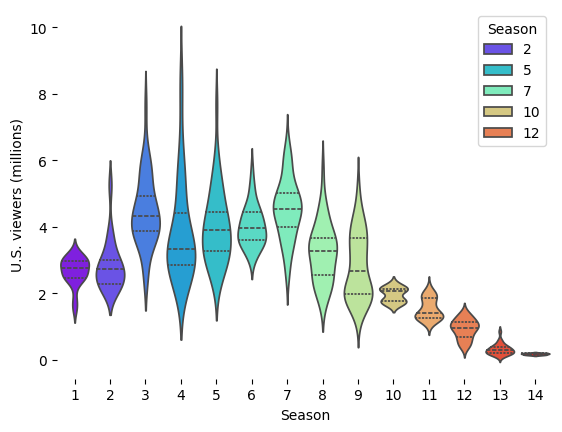

In [7]:
sns.violinplot(episode_data, x='Season', y='U.S. viewers (millions)', inner='quart',hue='Season', palette="rainbow")
sns.despine(top=True, right=True, bottom=True, left=True)

*Plot of the total viewership:*

<Axes: ylabel='U.S. viewers (millions)'>

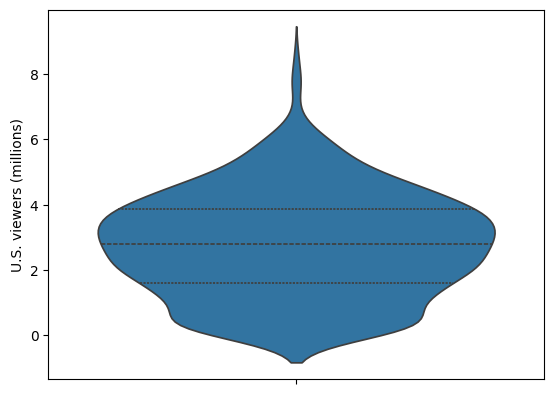

In [8]:
sns.violinplot(episode_data["U.S. viewers (millions)"], inner='quart')

(array([ 80.,  79.,  98., 110.,  95.,  57.,  29.,   7.,   2.,   2.]),
 array([0.08 , 0.928, 1.776, 2.624, 3.472, 4.32 , 5.168, 6.016, 6.864,
        7.712, 8.56 ]),
 <BarContainer object of 10 artists>)

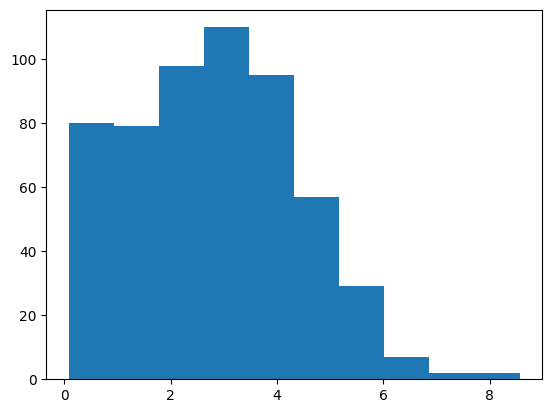

In [9]:
plt.hist(episode_data["U.S. viewers (millions)"])

##Likelyhood and Priors
Due to all the seasons seem to have very different distributions, with differing means, variances, and skews, we'll use a SkewStudentT. The mean will be about 3000 (since that's approximatly the mean of the data), and the mean will have a high variance since the data has such a high variance. The likelyhood will also have a high std deviation to be able to reach all the given values. And we'll have a high kurtosis and try to have a balanced skew, this is so the skew can be easily adjusted.

<Axes: >

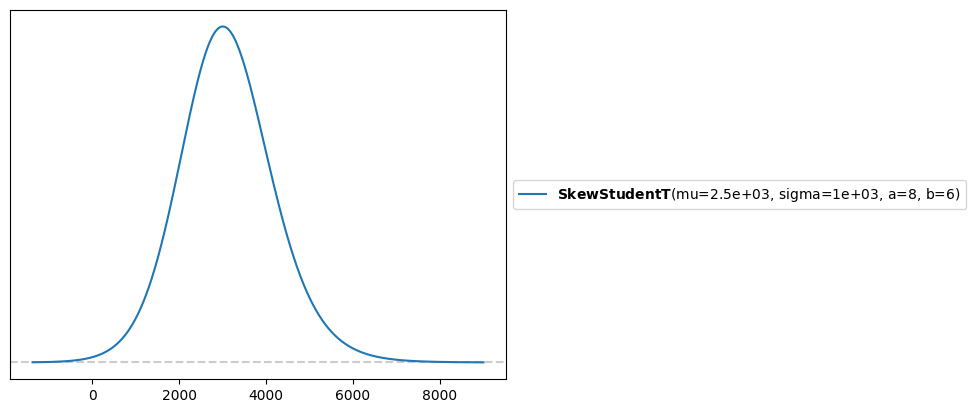

In [10]:
#Likelyhood
pz.SkewStudentT(mu = 2500, sigma = 1000, a = 8, b = 6).plot_pdf()

<Axes: >

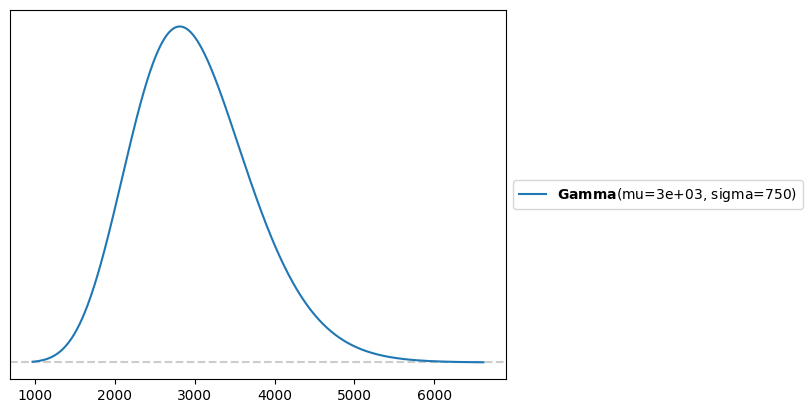

In [11]:
#Mu prior
pz.Gamma(mu = 3000, sigma = 750).plot_pdf()

<Axes: >

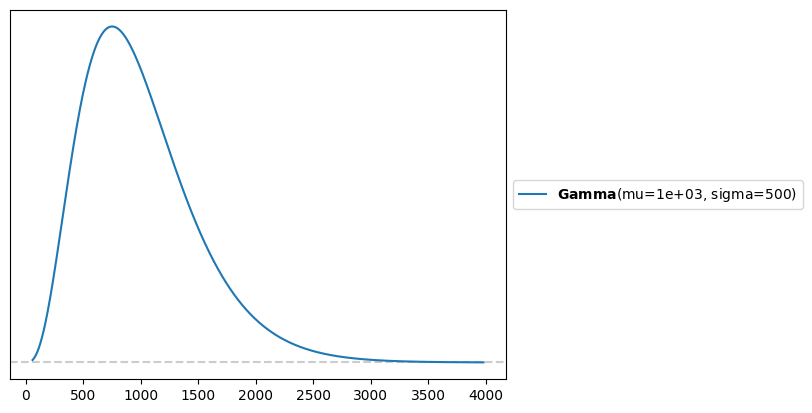

In [12]:
#Sigma prior
pz.Gamma(mu = 1000, sigma = 500).plot_pdf()

<Axes: >

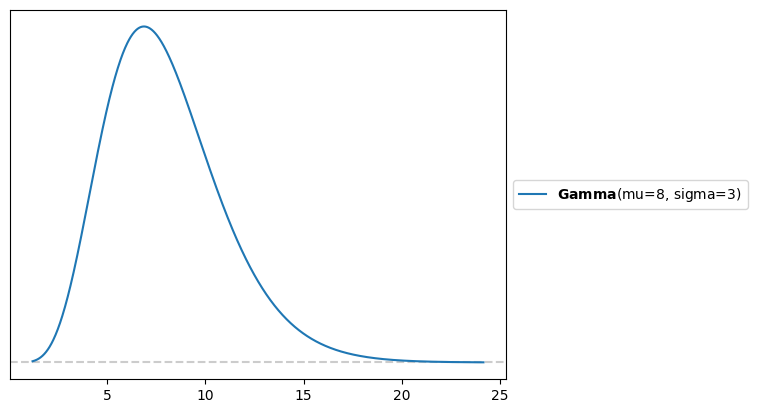

In [13]:
#a prior
pz.Gamma(mu = 8, sigma = 3).plot_pdf()

<Axes: >

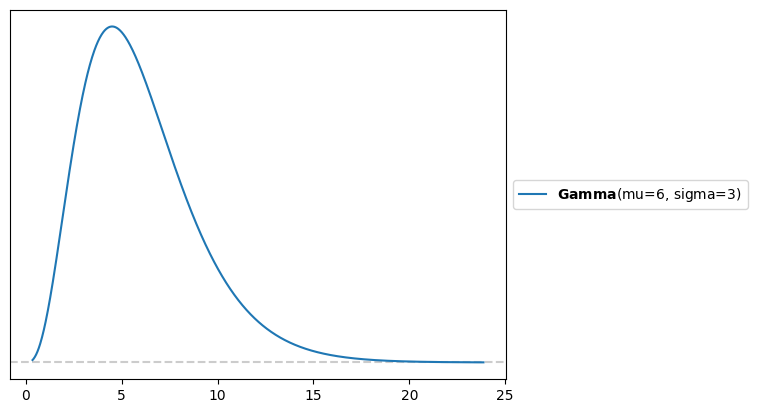

In [14]:
#b prior
pz.Gamma(mu = 6, sigma = 3).plot_pdf()

<Axes: >

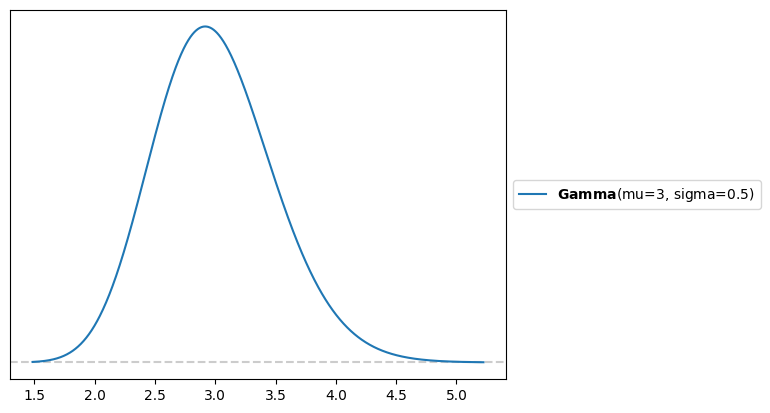

In [15]:
#mu hyper prior
pz.Gamma(mu=3.0, sigma=0.5).plot_pdf()

<Axes: >

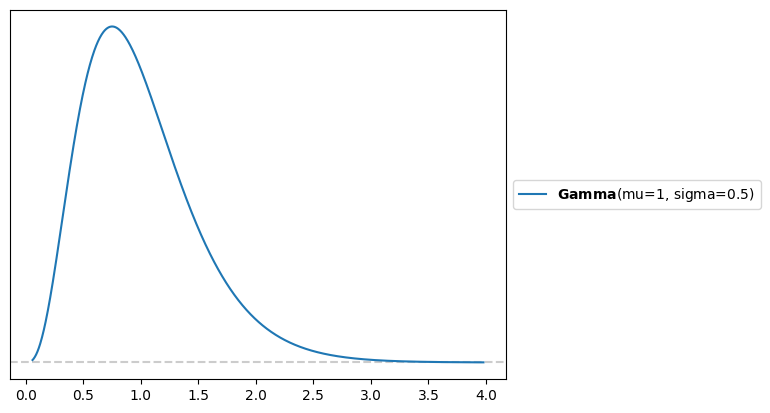

In [16]:
#sigma hyperprior
pz.Gamma(mu=1.0, sigma=0.5).plot_pdf()

For non-hierarchical model, this is all that'll be done for it, just applying it to each season seperatly.

A diagram of what the non-hierarchical is below.

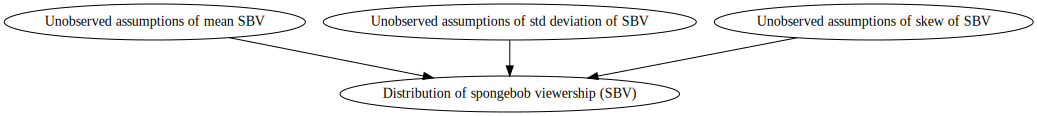

In [17]:
dag_sbv_nh = gv.Digraph(comment='sbv_dag_nh')

dag_sbv_nh.node('M', 'Unobserved assumptions of mean SBV')
dag_sbv_nh.node('S','Unobserved assumptions of std deviation of SBV')
dag_sbv_nh.node('A','Unobserved assumptions of skew of SBV')
dag_sbv_nh.node('D','Distribution of spongebob viewership (SBV)')

dag_sbv_nh.edges(['MD','SD','AD'])
dag_sbv_nh

 The main thing to determine is how the heirarchical model differs. Based on the data, there seems to be a correlation between season and the mean, so a hyperpriors may be important to the mu value. However, I don't think the standard deviation will be under the group effect.

 Here's what the heirarchical will look like.

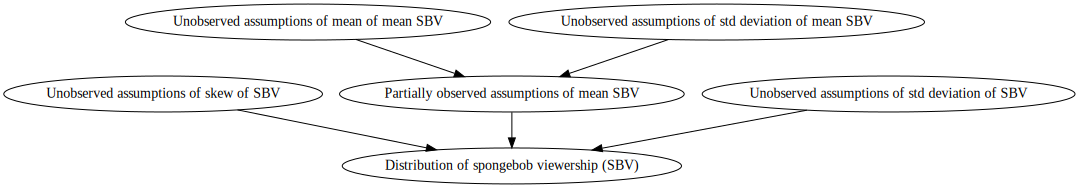

In [18]:
dag_sbv_h = gv.Digraph(comment='sbv_dag_h')

dag_sbv_h.node('A','Unobserved assumptions of skew of SBV')
dag_sbv_h.node('M', 'Partially observed assumptions of mean SBV')
dag_sbv_h.node('S','Unobserved assumptions of std deviation of SBV')
dag_sbv_h.node('D','Distribution of spongebob viewership (SBV)')
dag_sbv_h.node('N','Unobserved assumptions of mean of mean SBV')
dag_sbv_h.node('H','Unobserved assumptions of std deviation of mean SBV')

dag_sbv_h.edges(['MD','SD', 'NM', 'HM', 'AD'])
dag_sbv_h

##Non-Hierarchical Model

In [ ]:
with pm.Model(coords = ep_coords) as viewer_model_NH:
  #Priors
  μ = pm.Gamma("mu", mu=3.0, sigma=1.0, dims = "szn")
  sigma = pm.Gamma("sigma", mu=1.0, sigma=2.0,  dims = "szn")
  a = pm.Gamma("a",mu = 8, sigma = 3, dims = "szn")
  b = pm.Gamma("b",mu = 6, sigma = 3, dims = "szn")

  #Likelyhood
  y1 = pm.SkewStudentT("y1",
                       mu = μ[szn_idx],
                       sigma = sigma[szn_idx],
                       a = a[szn_idx],
                       b = b[szn_idx],
                       observed = episode_data['U.S. viewers (millions)'])

  sample_data_NH = pm.sample()

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

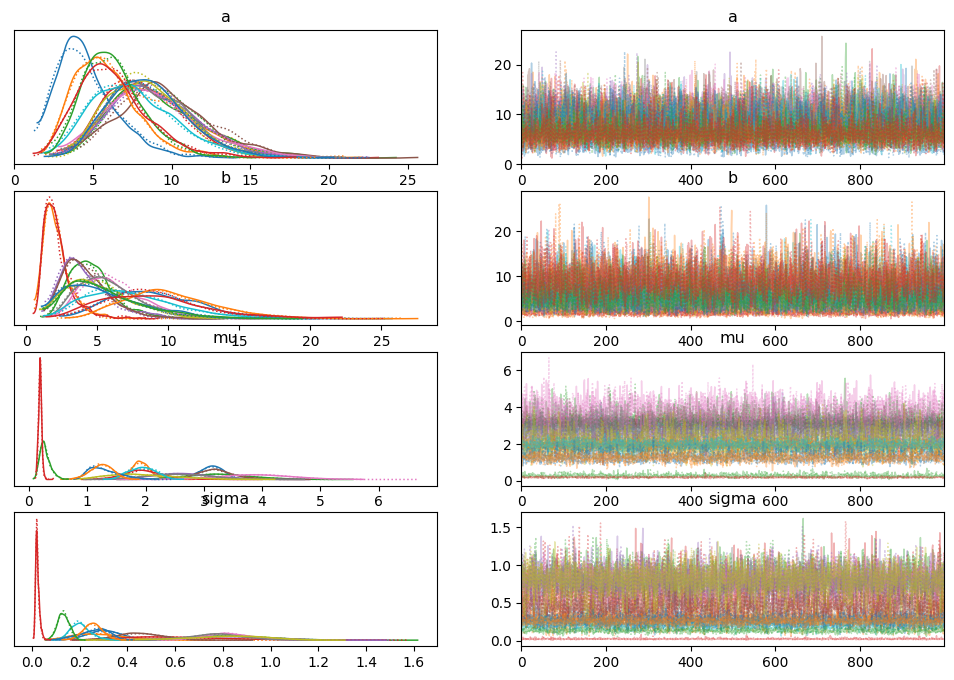

In [20]:
az.plot_trace(sample_data_NH)

In [21]:
az.rhat(sample_data_NH)

<xarray.Dataset> Size: 560B
Dimensions:  (szn: 14)
Coordinates:
  * szn      (szn) int64 112B 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables:
    a        (szn) float64 112B 1.001 1.001 1.002 1.002 ... 1.002 1.001 0.9993
    b        (szn) float64 112B 0.9996 1.001 1.002 1.006 ... 0.9999 1.002 1.006
    mu       (szn) float64 112B 1.005 1.001 0.9999 1.001 ... 0.9994 1.001 0.9997
    sigma    (szn) float64 112B 1.0 1.001 0.9996 1.004 ... 1.001 1.002 1.0 1.004

array([<Axes: >], dtype=object)

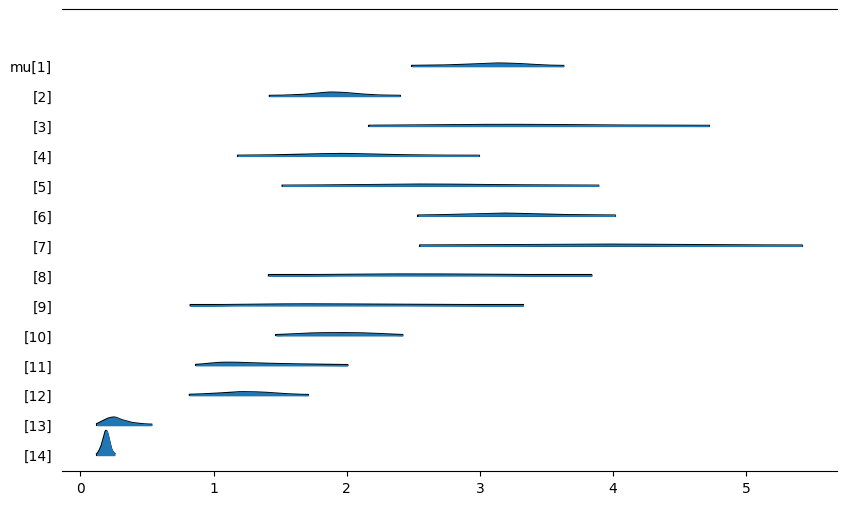

In [22]:
az.plot_forest(sample_data_NH, var_names=['mu'], combined=True, figsize=(10, 6), kind = 'ridgeplot', hdi_prob=0.98)

In [ ]:
pm.sample_posterior_predictive(sample_data_NH, model=viewer_model_NH, extend_inferencedata=True)

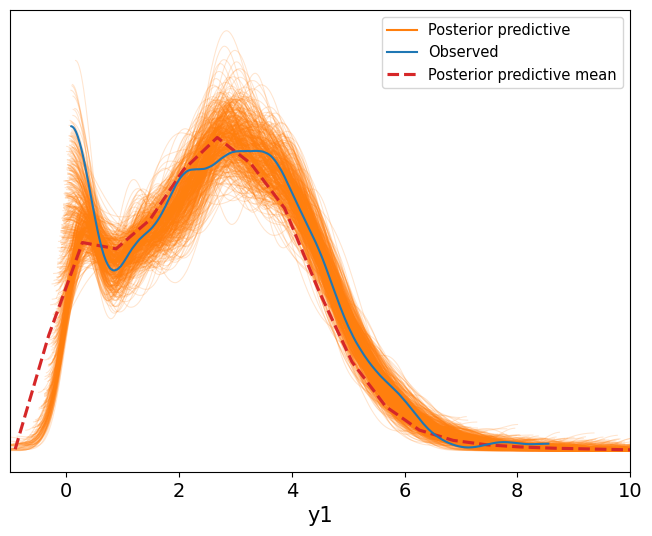

In [33]:
#Used Gemini to generate the ability to make a limit on the x axis
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_ppc(sample_data_NH, num_pp_samples=500, ax=ax, colors=["C1", "C0", "C3"])
ax.set_xlim(-1, 10)
plt.show()

##Hierarchical Model

In [ ]:
with pm.Model(coords = ep_coords) as viewer_model_H:
  #Hyperpriors
  mu_hp = pm.Gamma("mu_hp", mu=3.0, sigma=1.0)
  sig_hp = pm.Gamma("sig_hp", mu=1.0, sigma=2.0)
  #Priors
  μ = pm.Gamma("mu", mu=mu_hp, sigma=sig_hp, dims = "szn")
  sigma = pm.Gamma("sigma", mu=1.0, sigma=2.0,  dims = "szn")
  a = pm.Gamma("a",mu = 8, sigma = 3, dims = "szn")
  b = pm.Gamma("b",mu = 6, sigma = 3, dims = "szn")

  #Likelyhood
  y1 = pm.SkewStudentT("y1",
                       mu = μ[szn_idx],
                       sigma = sigma[szn_idx],
                       a = a[szn_idx],
                       b = b[szn_idx],
                       observed = episode_data['U.S. viewers (millions)'])

  sample_data_H = pm.sample()

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'mu_hp'}>,
        <Axes: title={'center': 'mu_hp'}>],
       [<Axes: title={'center': 'sig_hp'}>,
        <Axes: title={'center': 'sig_hp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

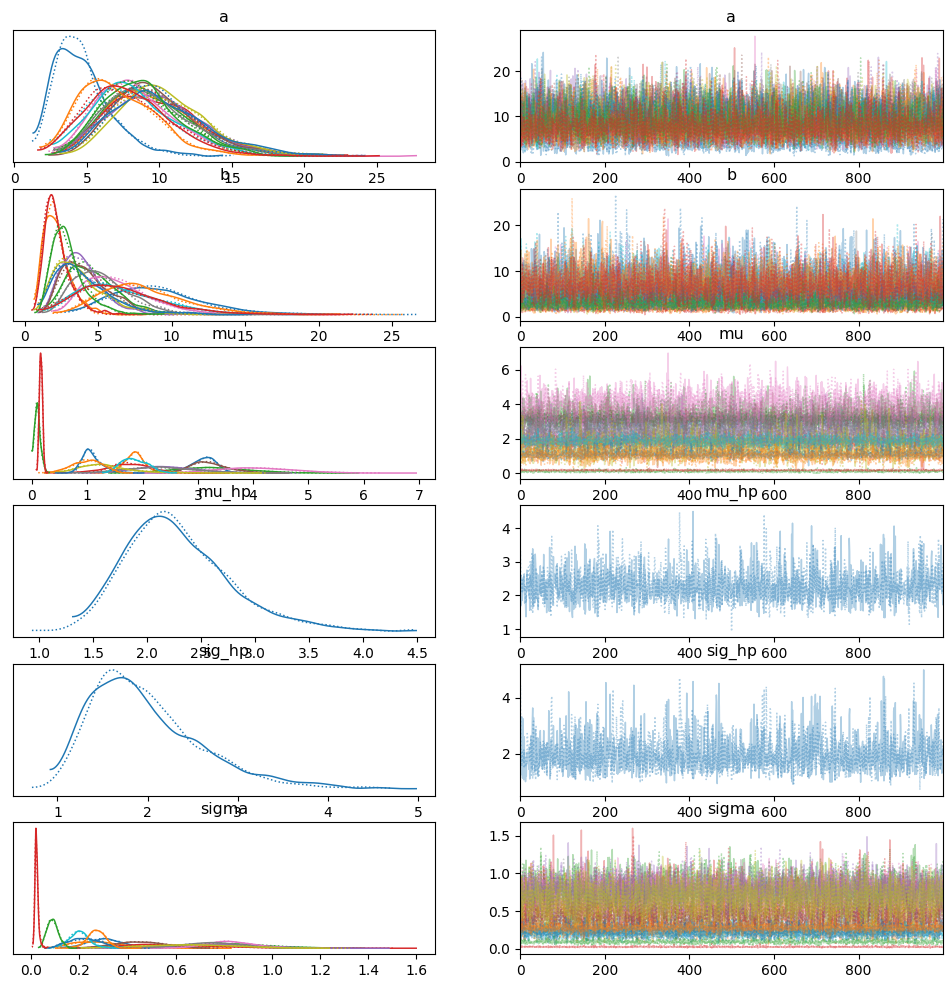

In [26]:
az.plot_trace(sample_data_H)

In [27]:
az.rhat(sample_data_H)

<xarray.Dataset> Size: 576B
Dimensions:  (szn: 14)
Coordinates:
  * szn      (szn) int64 112B 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables:
    a        (szn) float64 112B 1.0 1.001 1.004 1.004 ... 1.007 1.0 1.002 1.001
    b        (szn) float64 112B 1.001 1.002 1.001 0.9996 ... 1.003 1.001 1.001
    mu       (szn) float64 112B 1.0 1.0 0.9996 1.004 ... 1.003 1.0 1.001 1.0
    mu_hp    float64 8B 0.9994
    sig_hp   float64 8B 1.001
    sigma    (szn) float64 112B 0.9994 0.9996 1.001 1.0 ... 1.002 0.9997 1.002

array([<Axes: >], dtype=object)

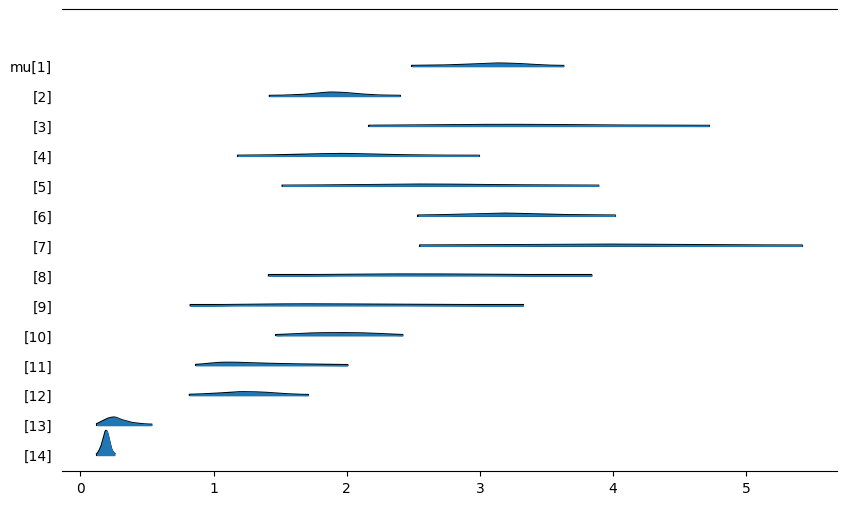

In [28]:
az.plot_forest(sample_data_NH, var_names=['mu'], combined=True, figsize=(10, 6), kind = 'ridgeplot', hdi_prob=0.98)

In [ ]:
pm.sample_posterior_predictive(sample_data_H, model=viewer_model_NH, extend_inferencedata=True)

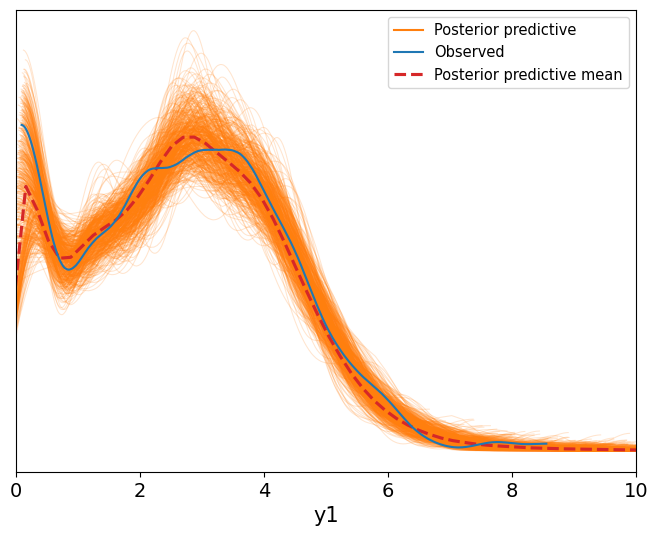

In [36]:
#Used Gemini to generate the ability to make a limit on the x axis
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_ppc(sample_data_H, num_pp_samples=500, ax=ax, colors=["C1", "C0", "C3"])
ax.set_xlim(0, 10)
plt.show()

##Conclusion

Both the models preform pretty well. But, the hierarchical model seems to fit better and handles viewership approaching zero better. This means that there is more likely a group effect among spongebob viewership across seasons along the mean then there being no group effect.